# Libreries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.
 
It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.
 
The concordance index is a value between 0 and 1 where:
 
0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""

import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [107]:
row_id_column_name = "id"

y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
y_pred = pd.DataFrame(y_pred)
y_pred.insert(0, row_id_column_name, range(len(y_pred)))

y_true = {
    'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 
    'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 
    'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}
    }
y_true = pd.DataFrame(y_true)
y_true.insert(0, row_id_column_name, range(len(y_true)))

score(y_true.copy(), y_pred.copy(), row_id_column_name)

0.75

# Load dataset

In [3]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
data_dictionary = pd.read_csv('data/data_dictionary.csv')

In [4]:
target = ['efs', 'efs_time']

In [5]:
ID = data_train.ID
Y_train = data_train[target]
X_train = data_train.drop(columns=target+['ID'])

<Axes: >

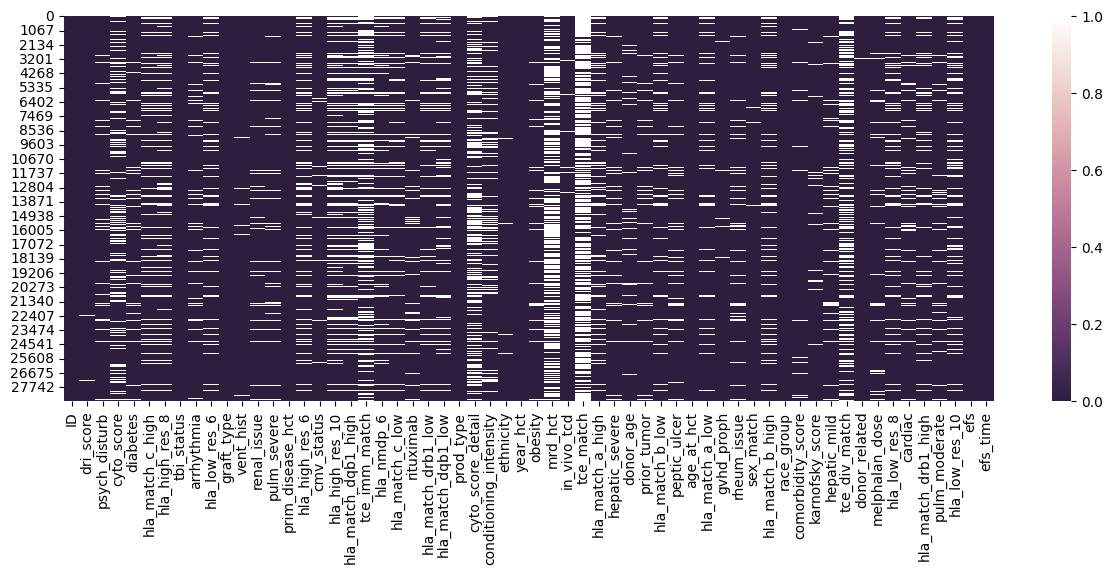

In [6]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data_train.isnull(), cmap=cmap)

# types columns

In [7]:
X_train.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [8]:
columns_object = X_train.select_dtypes(include=['object']).columns
columns_num = X_train.select_dtypes(include=['float', 'int']).columns

In [9]:
X_train_object = X_train[columns_object]
X_train_num = X_train[columns_num]

In [10]:
X_train_object.shape

(28800, 35)

## num

### Scaling the data

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num_scaler = scaler.transform(X_train_num)

In [21]:
dummy = {}
for i in range(len(X_train_num.columns)):
    dummy[X_train_num.columns[i]] = X_train_num_scaler[:,i]
X_train_num_scaler = pd.DataFrame(dummy)

### Plot missing values

<Axes: >

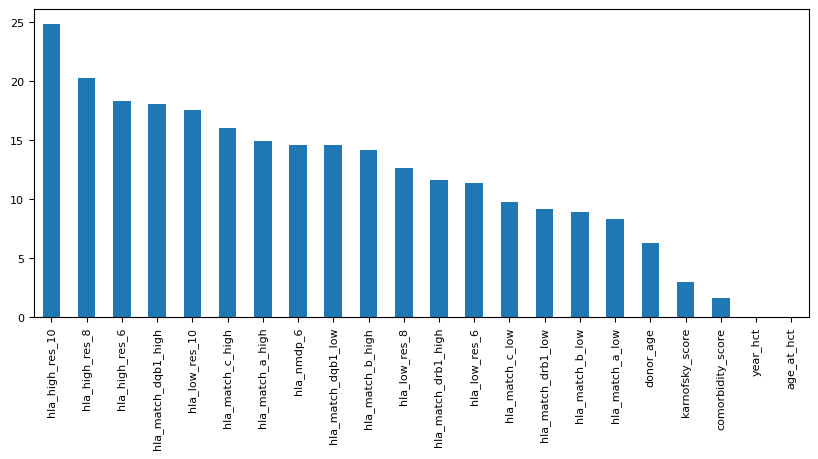

In [22]:
dummy = (X_train_num_scaler.isnull().mean()*100).sort_values(ascending=False)
dummy.plot.bar(fontsize=8, figsize=(10,4))

### Imputed

In [23]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
imputer.fit(X_train_num_scaler)

KNNImputer(n_neighbors=2)

In [16]:
X_train_num_scaler_imputer = imputer.transform(X_train_num_scaler)

In [17]:
dummy = {}
for i in range(len(X_train_num.columns)):
    dummy[X_train_num.columns[i]] = X_train_num_scaler_imputer[:,i]
X_train_num_scaler_imputer = pd.DataFrame(dummy)

<Axes: >

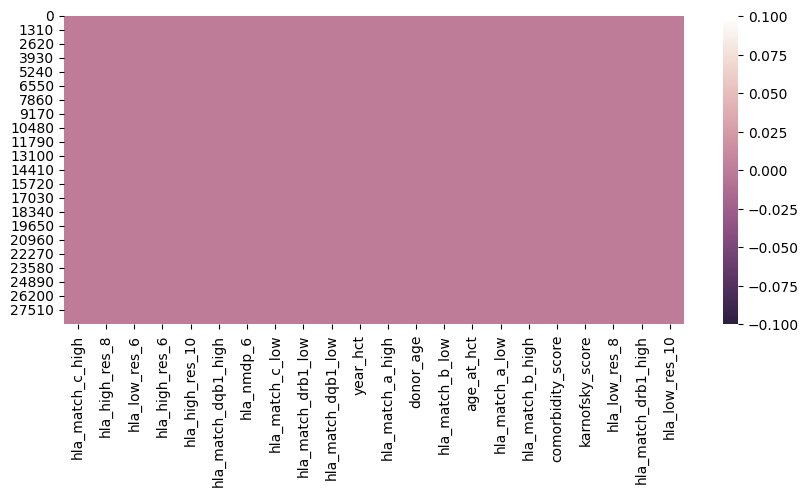

In [18]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(X_train_num_scaler_imputer.isnull(), cmap=cmap)

### Distribution

## categorical

<Axes: >

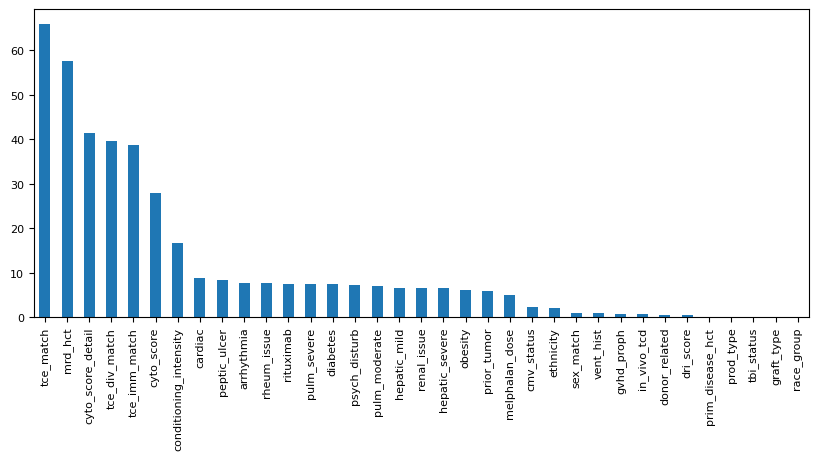

In [24]:
dummy = (X_train_object.isnull().mean()*100).sort_values(ascending=False)
dummy.plot.bar(fontsize=8, figsize=(10,4))

In [25]:
X_train_object_drop = X_train_object.drop(columns=dummy.head(5).keys().values.tolist())

<Axes: >

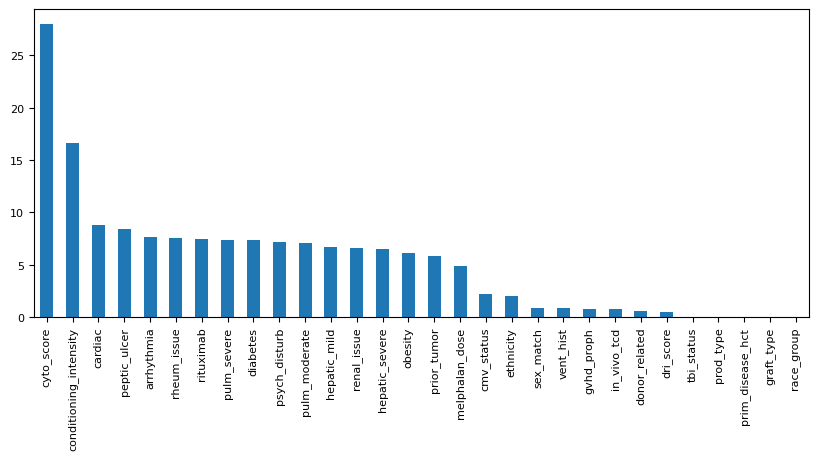

In [26]:
dummy = (X_train_object_drop.isnull().mean()*100).sort_values(ascending=False)
dummy.plot.bar(fontsize=8, figsize=(10,4))

In [27]:
X_train_object_drop.shape

(28800, 30)

<Axes: >

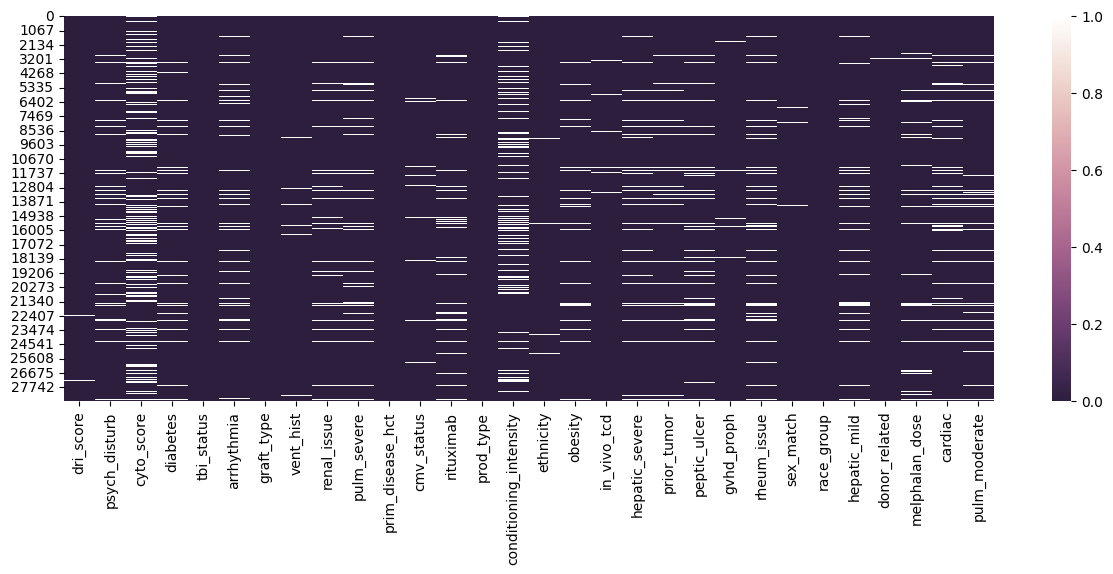

In [107]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(X_train_object_drop.isnull(), cmap=cmap)

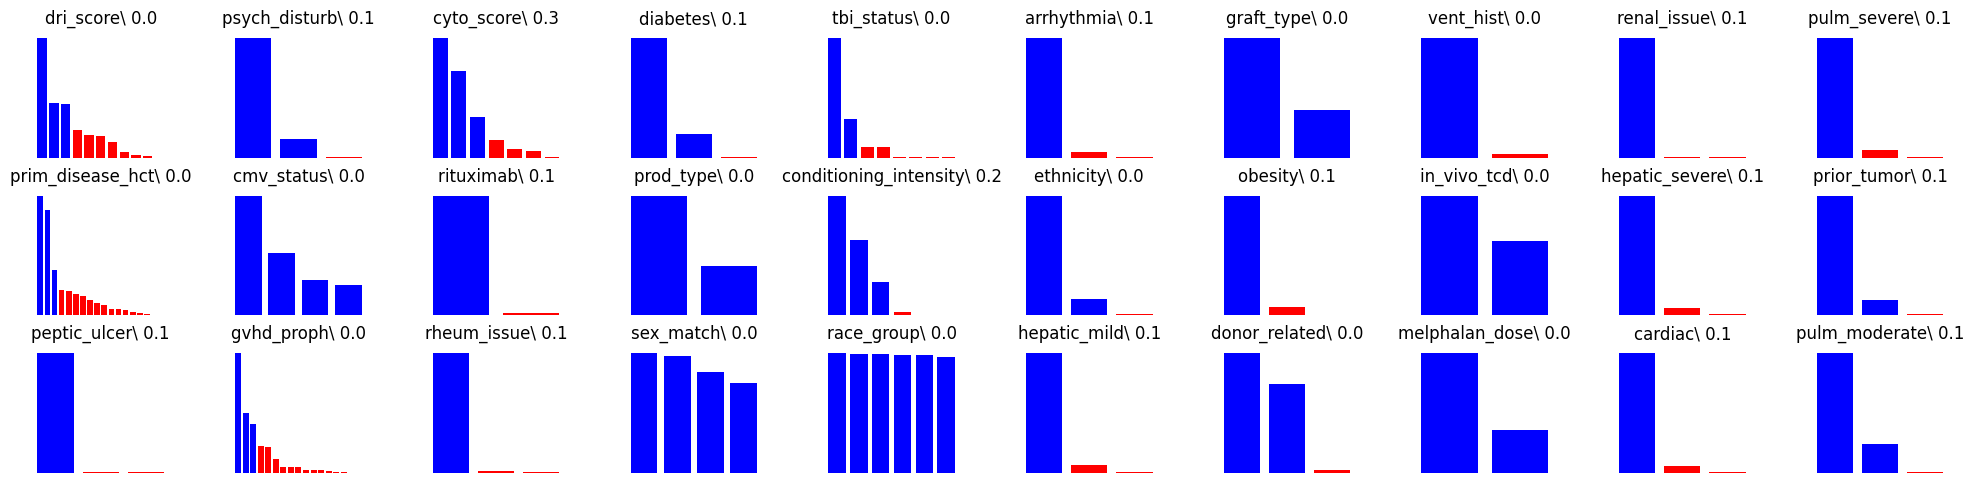

In [106]:
# Create subplots
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 5))
axs = axs.ravel()
fig.tight_layout(h_pad=0.2, w_pad=0.5)

# Loop through columns
for i, col in enumerate(X_train_object_drop.columns):
    # Get value counts as percentages
    value_counts = X_train_object_drop[col].value_counts(normalize=True) * 100
    percent_null = X_train_object_drop[col].isnull().sum()/28800
    
    # Get the indices and values
    categories = value_counts.index
    percentages = value_counts.values
    
    # Plot bars with conditional coloring
    #colors = ['red' if (val < 10 or pd.isna(val)) else 'blue' for val in percentages]
    colors = ['red' if (val < 10) else 'blue' for val in percentages]
    axs[i].bar(categories, percentages, color=colors)
    
    # Customize the subplot
    axs[i].axis('off')  # Remove axis
    axs[i].set_title(col+ '\ ' + str(round(percent_null,1) ))

plt.show()


In [127]:
drop_columns = ['psych_disturb', 'vent_hist', 'renal_issue', 'pulm_severe', 'rituximab', 'obesity', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac']

In [128]:
X_train_object_drop_drop = X_train_object_drop.drop(columns=drop_columns)

<Axes: >

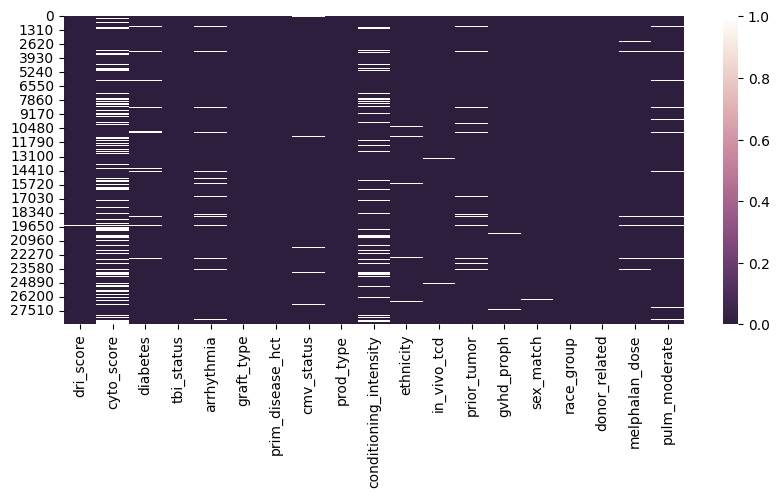

In [129]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(X_train_object_drop_drop.isnull(), cmap=cmap)

<Axes: xlabel='cyto_score'>

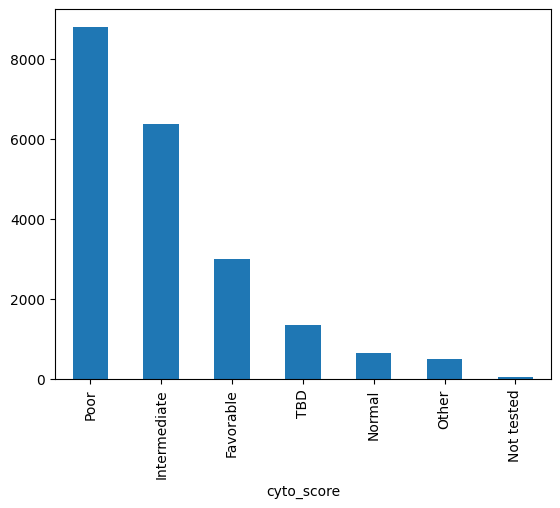

In [155]:
X_train_object_drop_drop.cyto_score.value_counts().plot(kind='bar')

In [160]:
X_train_object_drop_drop.cyto_score.isnull().sum()

np.int64(8068)

### Impute

In [173]:
categories_proportion = X_train_object_drop_drop.cyto_score.value_counts(normalize=True)

In [174]:
missing_index = X_train_object_drop_drop[X_train_object_drop_drop.cyto_score.isnull()].index

In [175]:
X_train_object_drop_drop.loc[missing_index, 'cyto_score'] = np.random.choice(categories_proportion.index, 
                                                                             size=len(missing_index),
                                                                             p=categories_proportion.values)


In [181]:
for col in X_train_object_drop_drop.columns:
    proportion = X_train_object_drop_drop[col].value_counts(normalize=True)
    missing_index = X_train_object_drop_drop.loc[X_train_object_drop_drop[col].isnull(),col].index


    X_train_object_drop_drop.loc[missing_index, col] = np.random.choice(proportion.index,
                                                                        size=len(missing_index),
                                                                        p=proportion.values                                                                        
                                                                        )

<Axes: >

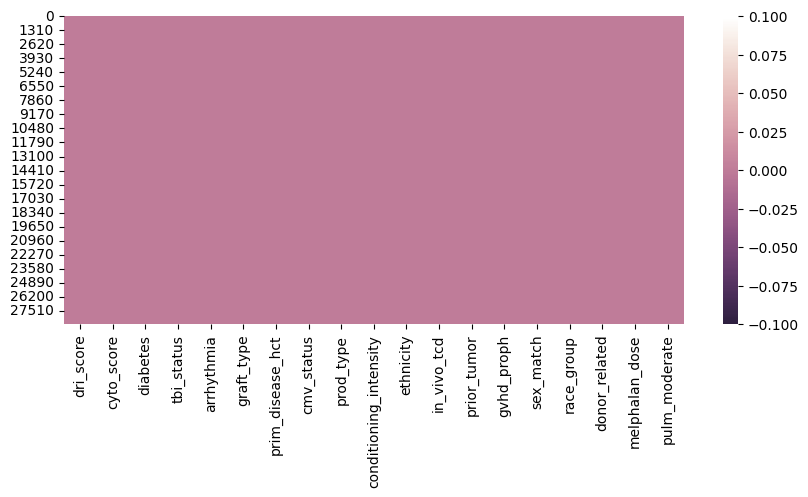

In [182]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(X_train_object_drop_drop.isnull(), cmap=cmap)

### Encoder

In [186]:
from sklearn.preprocessing import OneHotEncoder


In [199]:
cat_encoder = OneHotEncoder()
encoded_data = cat_encoder.fit_transform(X_train_object_drop_drop)

In [210]:
encoded_data.shape

(28800, 107)

In [205]:
cat_encoder.get_feature_names_out().shape

(107,)

In [209]:
encoded_df = pd.DataFrame(encoded_data.toarray(), 
                          columns=cat_encoder.get_feature_names_out())

# Join

In [215]:
result = pd.concat([X_train_num_scaler_imputer, encoded_df], axis=1)


In [217]:
result.shape

(28800, 129)

In [219]:
result.to_csv('./data/data_ready_train.csv')

In [233]:
result.isnull().sum(axis=0).sum()

np.int64(0)